In [1]:
##############################################################################
# 1) IMPORTS E CONFIGURAÇÕES
##############################################################################
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib as mpl
from pathlib import Path

# Checando GPU (opcional)
if tf.config.list_logical_devices('GPU'):
    print("Treinando com GPU disponível! :)")
else:
    print("GPU não detectada, usando CPU.")

# Criar pasta para salvar figuras 
IMAGES_PATH = Path("images") / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """ Salva a figura atual """
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

GPU não detectada, usando CPU.


In [2]:
##############################################################################
# 2) CARREGAR E VISUALIZAR MNIST
##############################################################################
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
print("Shapes:", X_train_full.shape, y_train_full.shape, "|", X_test.shape, y_test.shape)

# Converter para float32 e normalizar
X_train_full = X_train_full.astype(np.float32) / 255.
X_test = X_test.astype(np.float32) / 255.

X_train, X_val = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_val = y_train_full[:-5000], y_train_full[-5000:]

print("Tamanho do treino:", X_train.shape, y_train.shape)
print("Tamanho da validação:", X_val.shape, y_val.shape)
print("Tamanho do teste:", X_test.shape, y_test.shape)

Shapes: (60000, 28, 28) (60000,) | (10000, 28, 28) (10000,)
Tamanho do treino: (55000, 28, 28) (55000,)
Tamanho da validação: (5000, 28, 28) (5000,)
Tamanho do teste: (10000, 28, 28) (10000,)


In [4]:
##############################################################################
# 3) DEFINIR O VARIATIONAL AUTOENCODER (CONVOLUCIONAL)
##############################################################################
class Sampling(tf.keras.layers.Layer):
    """
    Camada para reparametrização: z = mu + exp(log_var * 0.5)*epsilon
    """
    def call(self, inputs):
        mean, log_var = inputs
        eps = tf.random.normal(tf.shape(log_var), dtype=tf.float32)  # Garante float32
        return mean + tf.exp(log_var / 2) * eps

codings_size = 16  # Dimensão do espaço latente

# ENCODER
inputs = tf.keras.layers.Input(shape=[28, 28], dtype=tf.float32)
Z = keras.layers.Reshape([28, 28, 1], dtype=tf.float32)(inputs)

Z = keras.layers.Conv2D(16, 3, padding="same", activation="relu", dtype=tf.float32)(Z)
Z = keras.layers.MaxPool2D(pool_size=2)(Z)
Z = keras.layers.BatchNormalization(dtype='float32')(Z)

Z = keras.layers.Conv2D(64, 3, padding="same", activation="relu", dtype=tf.float32)(Z)
Z = keras.layers.MaxPool2D(pool_size=2)(Z)
Z = keras.layers.BatchNormalization(dtype='float32')(Z)

Z = keras.layers.Flatten(dtype=tf.float32)(Z)
Z = keras.layers.Dense(30, activation='sigmoid', dtype=tf.float32)(Z)

codings_mean = tf.keras.layers.Dense(codings_size, dtype=tf.float32)(Z)
codings_log_var = tf.keras.layers.Dense(codings_size, dtype=tf.float32)(Z)


codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings],
    name="variational_encoder"
)

# DECODER
decoder_inputs = tf.keras.layers.Input(shape=[codings_size], dtype=tf.float32)
x = keras.layers.Dense(7 * 7 * 64, dtype=tf.float32)(decoder_inputs)
x = keras.layers.Reshape((7, 7, 64), dtype=tf.float32)(x)
x = keras.layers.Conv2DTranspose(64, 3, padding='same', activation='relu', dtype=tf.float32)(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.Conv2DTranspose(16, 3, padding='same', activation='relu', dtype=tf.float32)(x)
x = keras.layers.UpSampling2D(2)(x)

outputs = keras.layers.Conv2DTranspose(1, 3, padding='same', activation='relu', dtype=tf.float32)(x)

variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

# MONTAR O VAE
_, _, codings_ = variational_encoder(inputs)
reconstructions = variational_decoder(codings_)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])


In [7]:
##############################################################################
# 4) FUNÇÃO DE PERDA (RECONSTRUÇÃO + KL) DENTRO DO MODELO
##############################################################################

# Criar um modelo customizado para o VAE que adiciona a KL loss corretamente
class VariationalAutoencoder(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VariationalAutoencoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        codings_mean, codings_log_var, codings = self.encoder(inputs)
        reconstructed = self.decoder(codings)

        # Calcula a KL Divergence (agora dentro do fluxo do modelo)
        kl_loss = -0.5 * tf.reduce_sum(
            1.0 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
            axis=-1
        )
        kl_loss = tf.reduce_mean(kl_loss) / 784.0  # Normalização

        self.add_loss(kl_loss)  # Adiciona KL como uma perda extra ao modelo
        return reconstructed

# Criar o modelo final do VAE
variational_ae = VariationalAutoencoder(variational_encoder, variational_decoder)

# Compilar modelo com perda de reconstrução
variational_ae.compile(
    loss="mse",  # ou 'binary_crossentropy'
    optimizer="adam"
)


In [8]:
##############################################################################
# 5) TREINAMENTO DO VAE
##############################################################################
history_vae = variational_ae.fit(
    X_train, X_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_val, X_val)
)

Epoch 1/20


c:\Users\lucas\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_12']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
c:\Users\lucas\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_25']
Received: inputs=Tensor(shape=(None, 16))
  warnings.warn(msg)


430/430 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.0625 - val_loss: 0.0445
Epoch 2/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0437 - val_loss: 0.0408
Epoch 3/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0407 - val_loss: 0.0397
Epoch 4/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0396 - val_loss: 0.0389
Epoch 5/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0389 - val_loss: 0.0385
Epoch 6/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0385 - val_loss: 0.0380
Epoch 7/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0381 - val_loss: 0.0376
Epoch 8/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0379 - val_loss: 0.0376
Epoch 9/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0376 - val_loss: 0.0373
Epoch 10/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0373 - val_loss: 0.0369
Epoch 11/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0372 - val_loss: 0.0369
Epoch 12/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/st

 60/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

c:\Users\lucas\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_12']
Received: inputs=Tensor(shape=(32, 28, 28))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


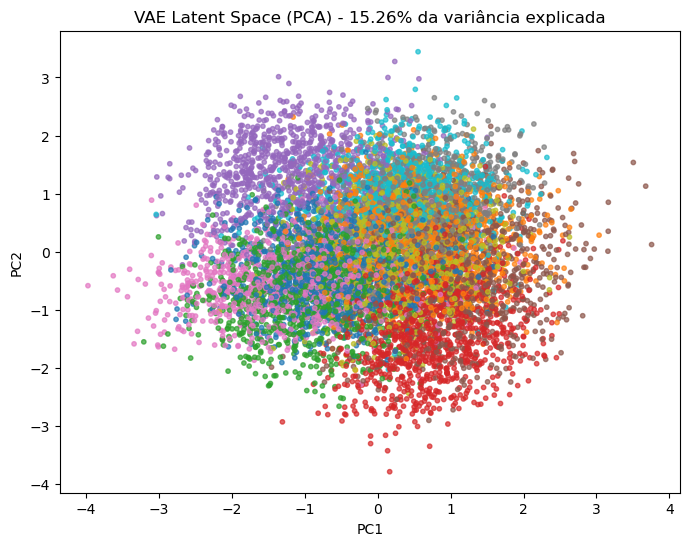

In [9]:
##############################################################################
# 6) VISUALIZANDO O ESPAÇO LATENTE com PCA
##############################################################################
_, _, X_val_latent = variational_encoder.predict(X_test)

# PCA para variância explicada
pca = PCA(n_components=2)
X_val_2D_pca = pca.fit_transform(X_val_latent)
var_exp_total = 100.0 * pca.explained_variance_ratio_.sum()

plt.figure(figsize=(8,6))
plt.scatter(X_val_2D_pca[:, 0], X_val_2D_pca[:, 1], c=y_test, cmap='tab10', s=10, alpha=0.7)
plt.title(f"VAE Latent Space (PCA) - {var_exp_total:.2f}% da variância explicada")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()